##### Copyright 2020 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.


## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.


In [2]:
# %pip uninstall pydot
# %pip uninstall graphviz
# %pip install pydot
# %pip install graphviz

# %pip install pydot graphviz
# %pip install visualkeras

In [3]:
# # Step 1: Install TensorFlow and Datasets
# %pip install -U -q tensorflow tensorflow_datasets

# # Step 2: Install Wrapt
# %pip install wrapt==1.14.1

# # Step 3: Install Visualization Libraries
# %pip install matplotlib seaborn

# # Step 4: Install PySoundFile
# %pip install pysoundfile

# # Step 5: Reinstall TensorFlow I/O
# # !pip uninstall -y tensorflow-io 
# %pip install tensorflow-io
# %pip install --upgrade tensorflow

# %pip install nbformat

# # Step 6: Install IPykernel
# %pip install ipykernel

# %pip install ipynb

# %pip install pickleshare

# %pip install librosa

# %pip install AudioSegment

# %pip install pydot

# %pip install graphviz

# %pip install "numpy<2"



In [ ]:

import pathlib
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
# import tensorflow_io as tfio
from IPython import get_ipython
import matplotlib.pyplot as plt
from collections import Counter

import seaborn as sns
# from tensorflow.keras.mixed_precision import set_global_policy
# from sklearn.metrics import confusion_matrix

DATA_DIR = pathlib.Path('data')

SECONDS = 1
BATCH_SIZE = 256
EPOCHS = 1000
RUNS_FIND_GOOD_AI = 1
RUNS_CREATE_AI = 20

mel_spectogram = True


# small Dataset
TRAIN_DIR = pathlib.Path('data/small_train_ds')
TEST_DIR = pathlib.Path('data/small_test_ds')
VAL_DIR = pathlib.Path('data/small_val_ds')

# # medium Dataset
# TRAIN_DIR = pathlib.Path('data/medium_train_ds')
# VAL_DIR = pathlib.Path('data/medium_val_ds')
# TEST_DIR = pathlib.Path('data/medium_test_ds')


# # large Dataset
# TRAIN_DIR = pathlib.Path('data/large_train_ds')
# VAL_DIR = pathlib.Path('data/large_val_ds')
# TEST_DIR = pathlib.Path('data/medium_test_ds')

# # no_mod Dataset
# TRAIN_DIR = pathlib.Path('data/no_mod_train_ds')
# VAL_DIR = pathlib.Path('data/no_mod_val_ds')
# TEST_DIR = pathlib.Path('data/no_mod_test_ds')


import ipynb.fs.defs.audio_extraction as audio_extraction
import ipynb.fs.defs.build_database as build_database
import ipynb.fs.defs.build_spectogram_ds as wave_to_spec
import ipynb.fs.defs.build_train_model as build_train_model
import ipynb.fs.defs.handle_ai_model as handle_ai_model



# GPU konfigurieren
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Speicherwachstum für GPUs aktiviert.")
        tf.config.set_visible_devices(gpus[0], 'GPU')  # Erste GPU auswählen
        print(f"Verwendete GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(f"Fehler bei der GPU-Konfiguration: {e}")
else:
    print("Keine GPUs gefunden. TensorFlow läuft auf der CPU.")

2.10.0
Speicherwachstum für GPUs aktiviert.
Verwendete GPU: /physical_device:GPU:0


# Extract

In [5]:
def notebook_extract():
    audio_extraction.extract_zip(TRAIN_DIR, DATA_DIR)
    print('-' * 50)  
    audio_extraction.extract_zip(TEST_DIR, DATA_DIR)
    print('-' * 50)  
    audio_extraction.extract_zip(VAL_DIR, DATA_DIR)
    print('-' * 50)
    print('-' * 50)  
    audio_extraction.rename_audio_files(DATA_DIR)
    print('-' * 50)
    print('-' * 50)  
    # audio_extraction.process_directory(TRAIN_DIR) 
    # audio_extraction.process_directory(VAL_DIR)
    # audio_extraction.process_directory(TEST_DIR)  

notebook_extract()

Das Verzeichnis data\small_train_ds existiert bereits. Überspringe das Extrahieren.
--------------------------------------------------
Das Verzeichnis data\small_test_ds existiert bereits. Überspringe das Extrahieren.
--------------------------------------------------
Das Verzeichnis data\small_val_ds existiert bereits. Überspringe das Extrahieren.
--------------------------------------------------
--------------------------------------------------
renaming of data/data complete
renaming of data/large_train_ds complete
renaming of data/orig-16-44-mono complete
renaming of data/upscale-from-mp3-128 complete
renaming of data/large_train_ds_splits complete
renaming of data/orig-16-44-mono complete
renaming of data/upscale-from-mp3-128 complete
renaming of data/large_val_ds complete
renaming of data/orig-16-44-mono complete
renaming of data/upscale-from-mp3-128 complete
renaming of data/large_val_ds_splits complete
renaming of data/orig-16-44-mono complete
renaming of data/upscale-from-mp3

# Database

In [6]:
train_ds, val_ds, test_ds, label_names = build_database.run(TRAIN_DIR, TEST_DIR, DATA_DIR, VAL_DIR, SECONDS, BATCH_SIZE)

Split Audio Data in 1
Output directory already exists: data\small_train_ds_splits. Skipping splitting.
Output directory already exists: data\small_val_ds_splits. Skipping splitting.
Output directory already exists: data\small_test_ds_splits. Skipping splitting.
Found 298 files belonging to 2 classes.
Found 56 files belonging to 2 classes.
Found 75 files belonging to 2 classes.


# Convert waveforms to spectrograms

Loaded label_names (before play): ['orig-16-44-mono' 'upscale-from-mp3-128']


i:\Uni-Git\Master\Tutorial\build_spectogram_ds.ipynb:136: RuntimeWarning: invalid value encountered in log
  "    print('Label:', label)\n",


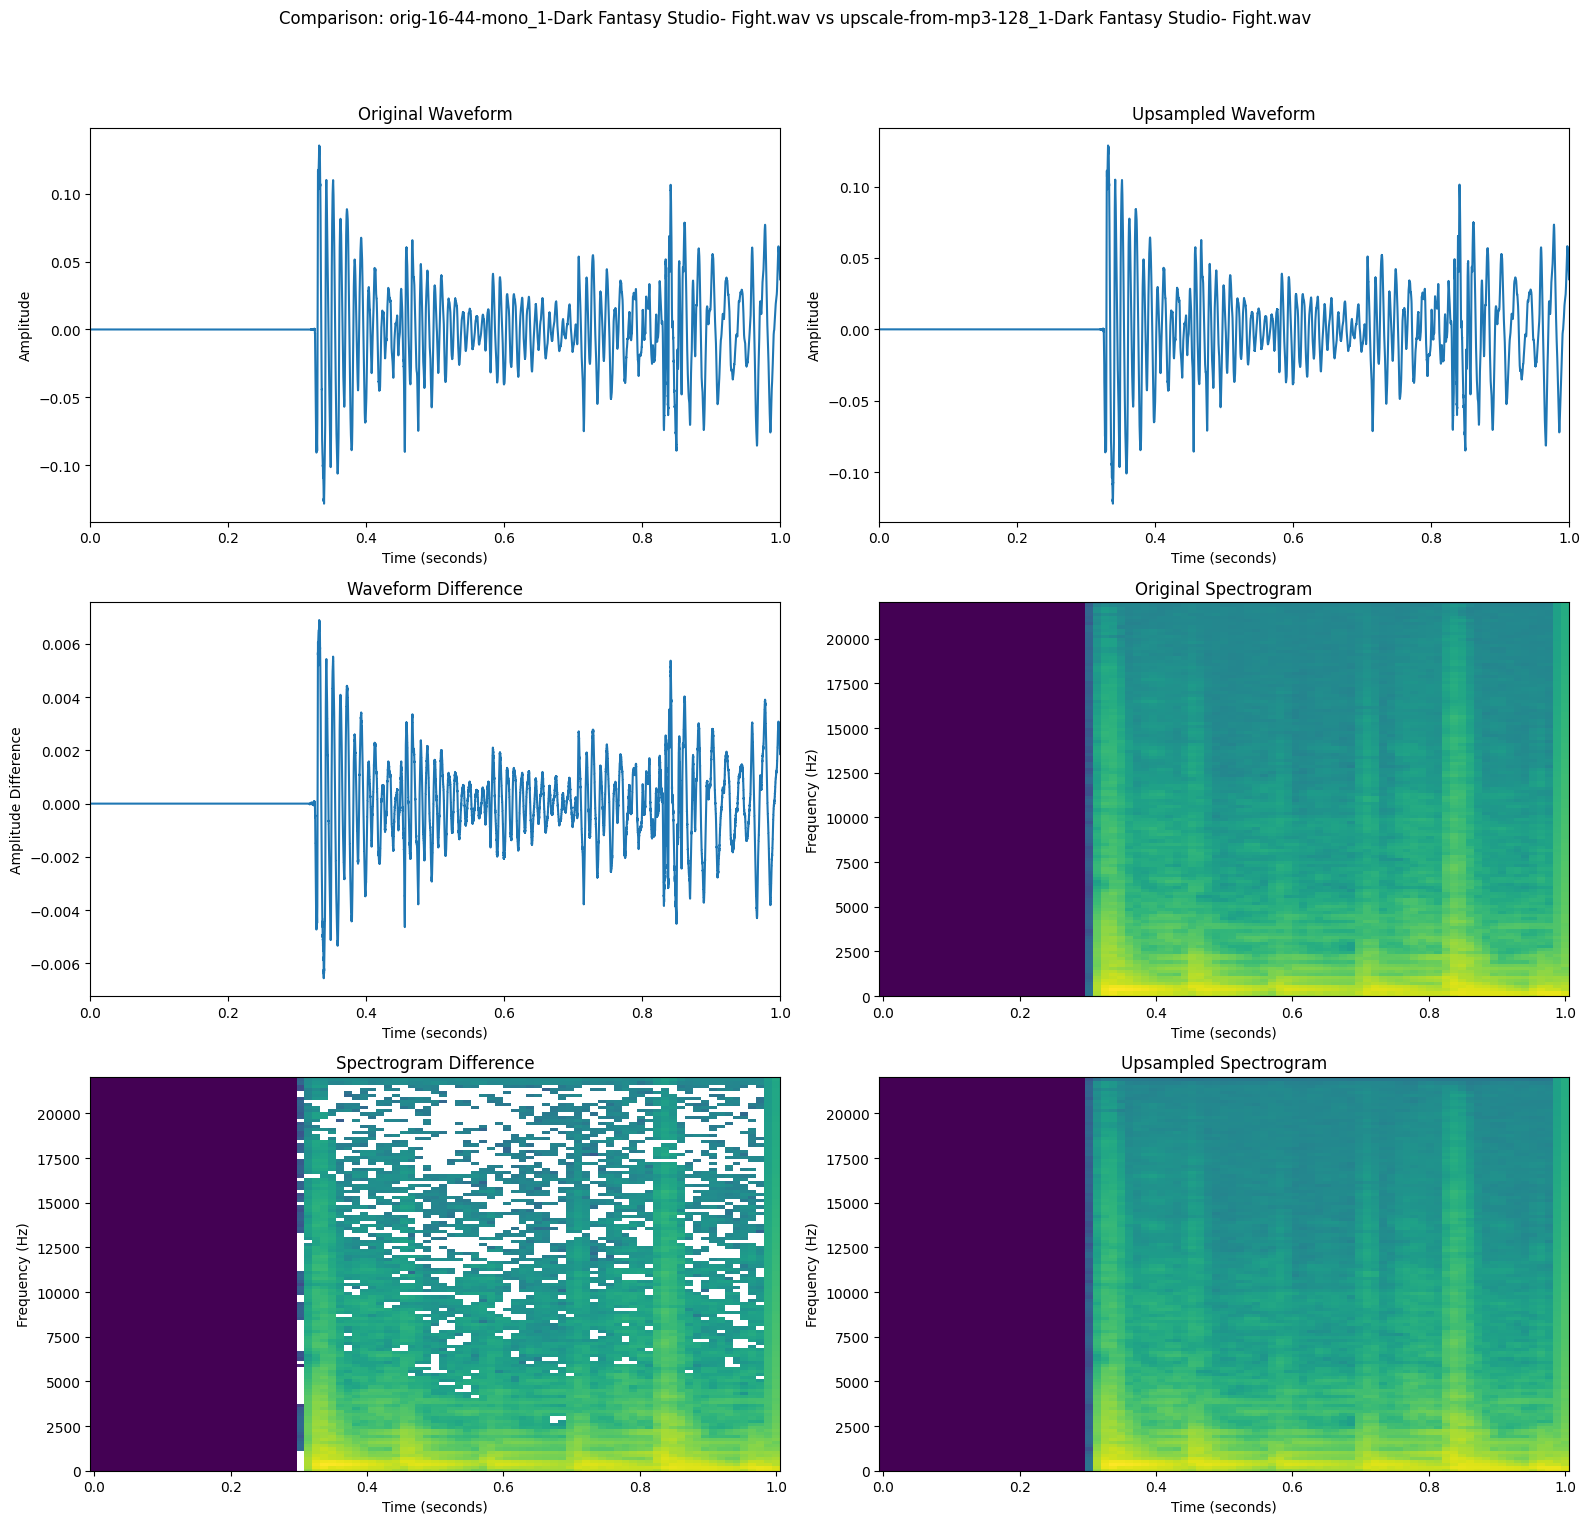

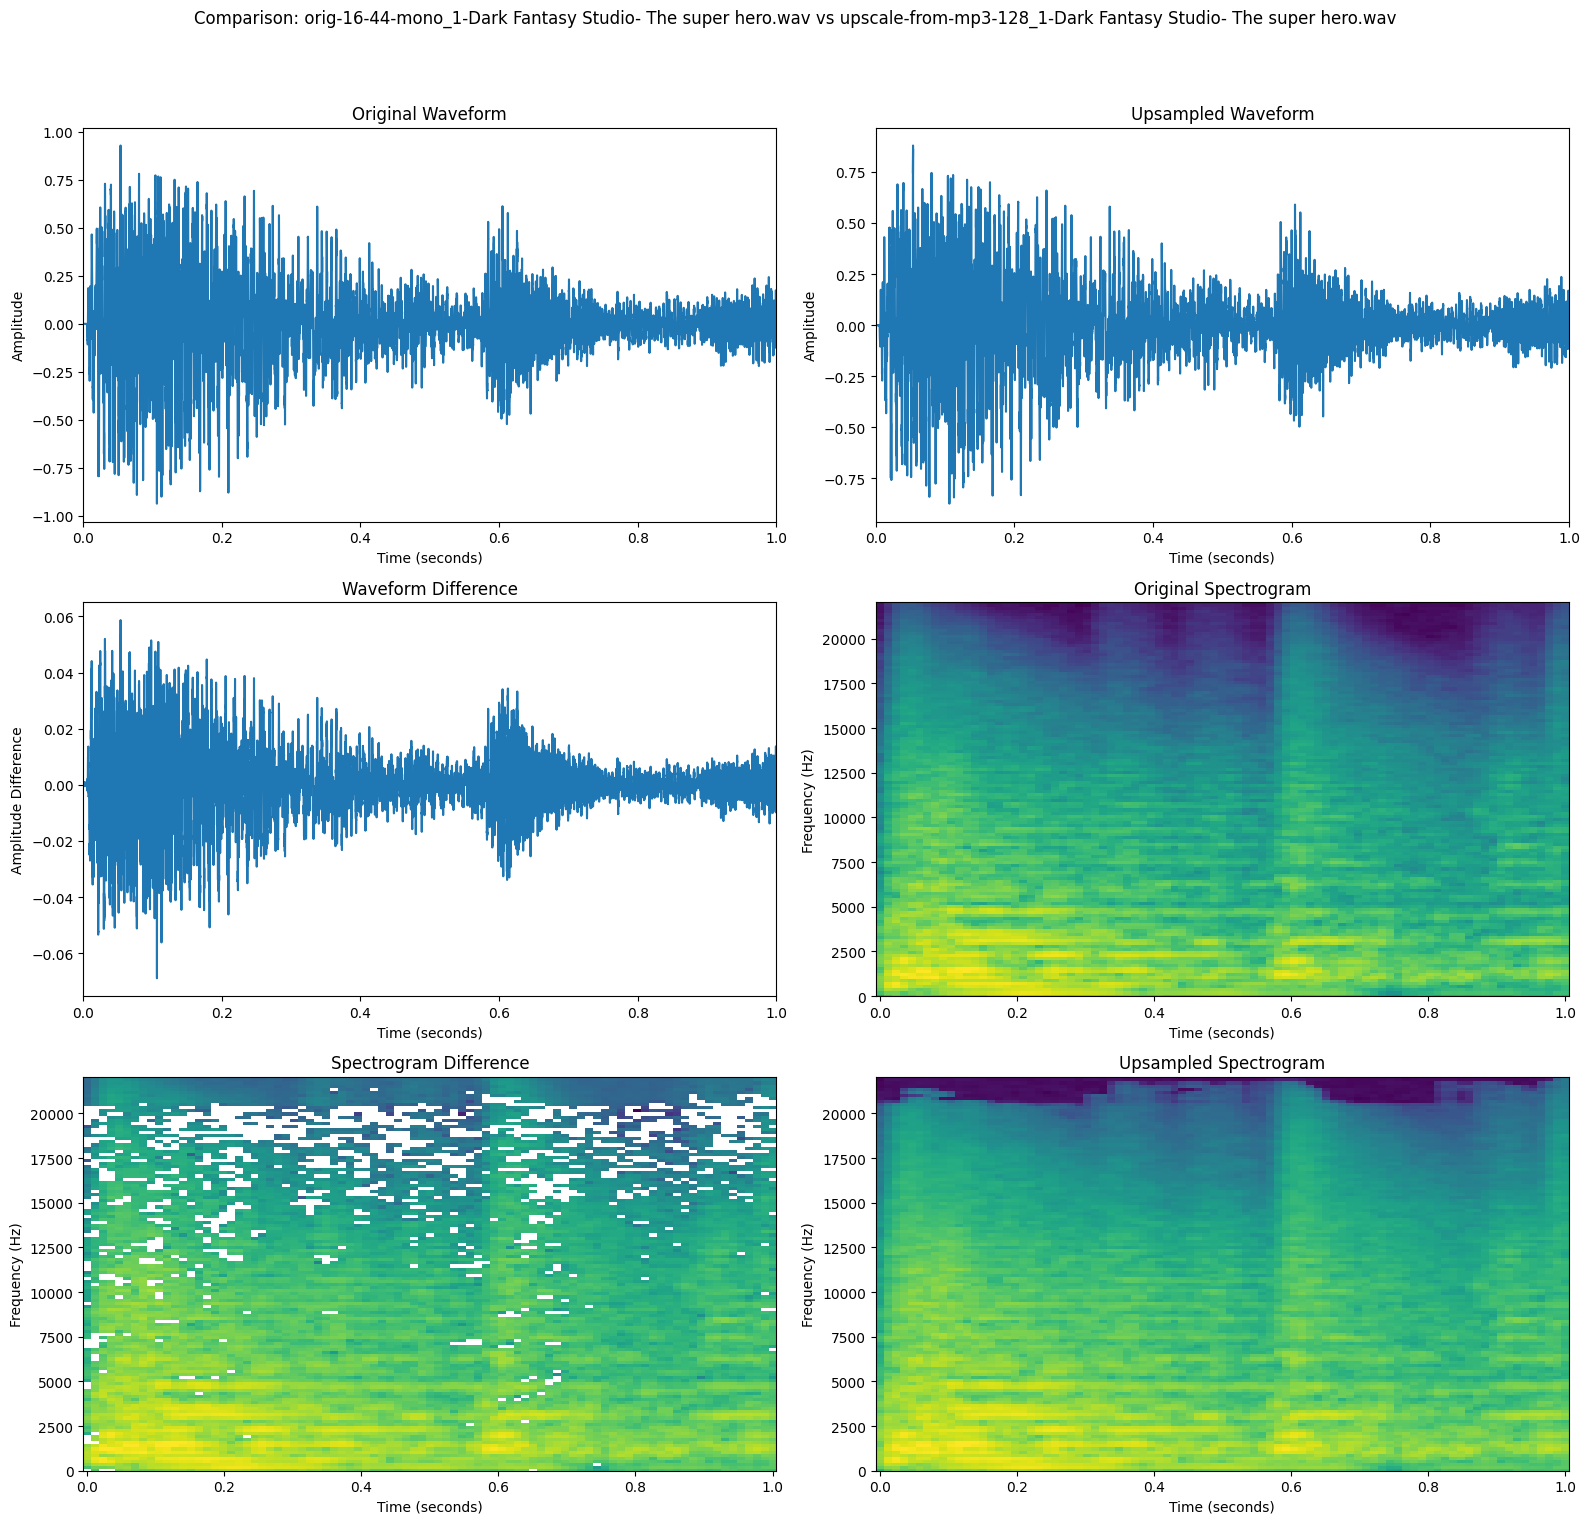

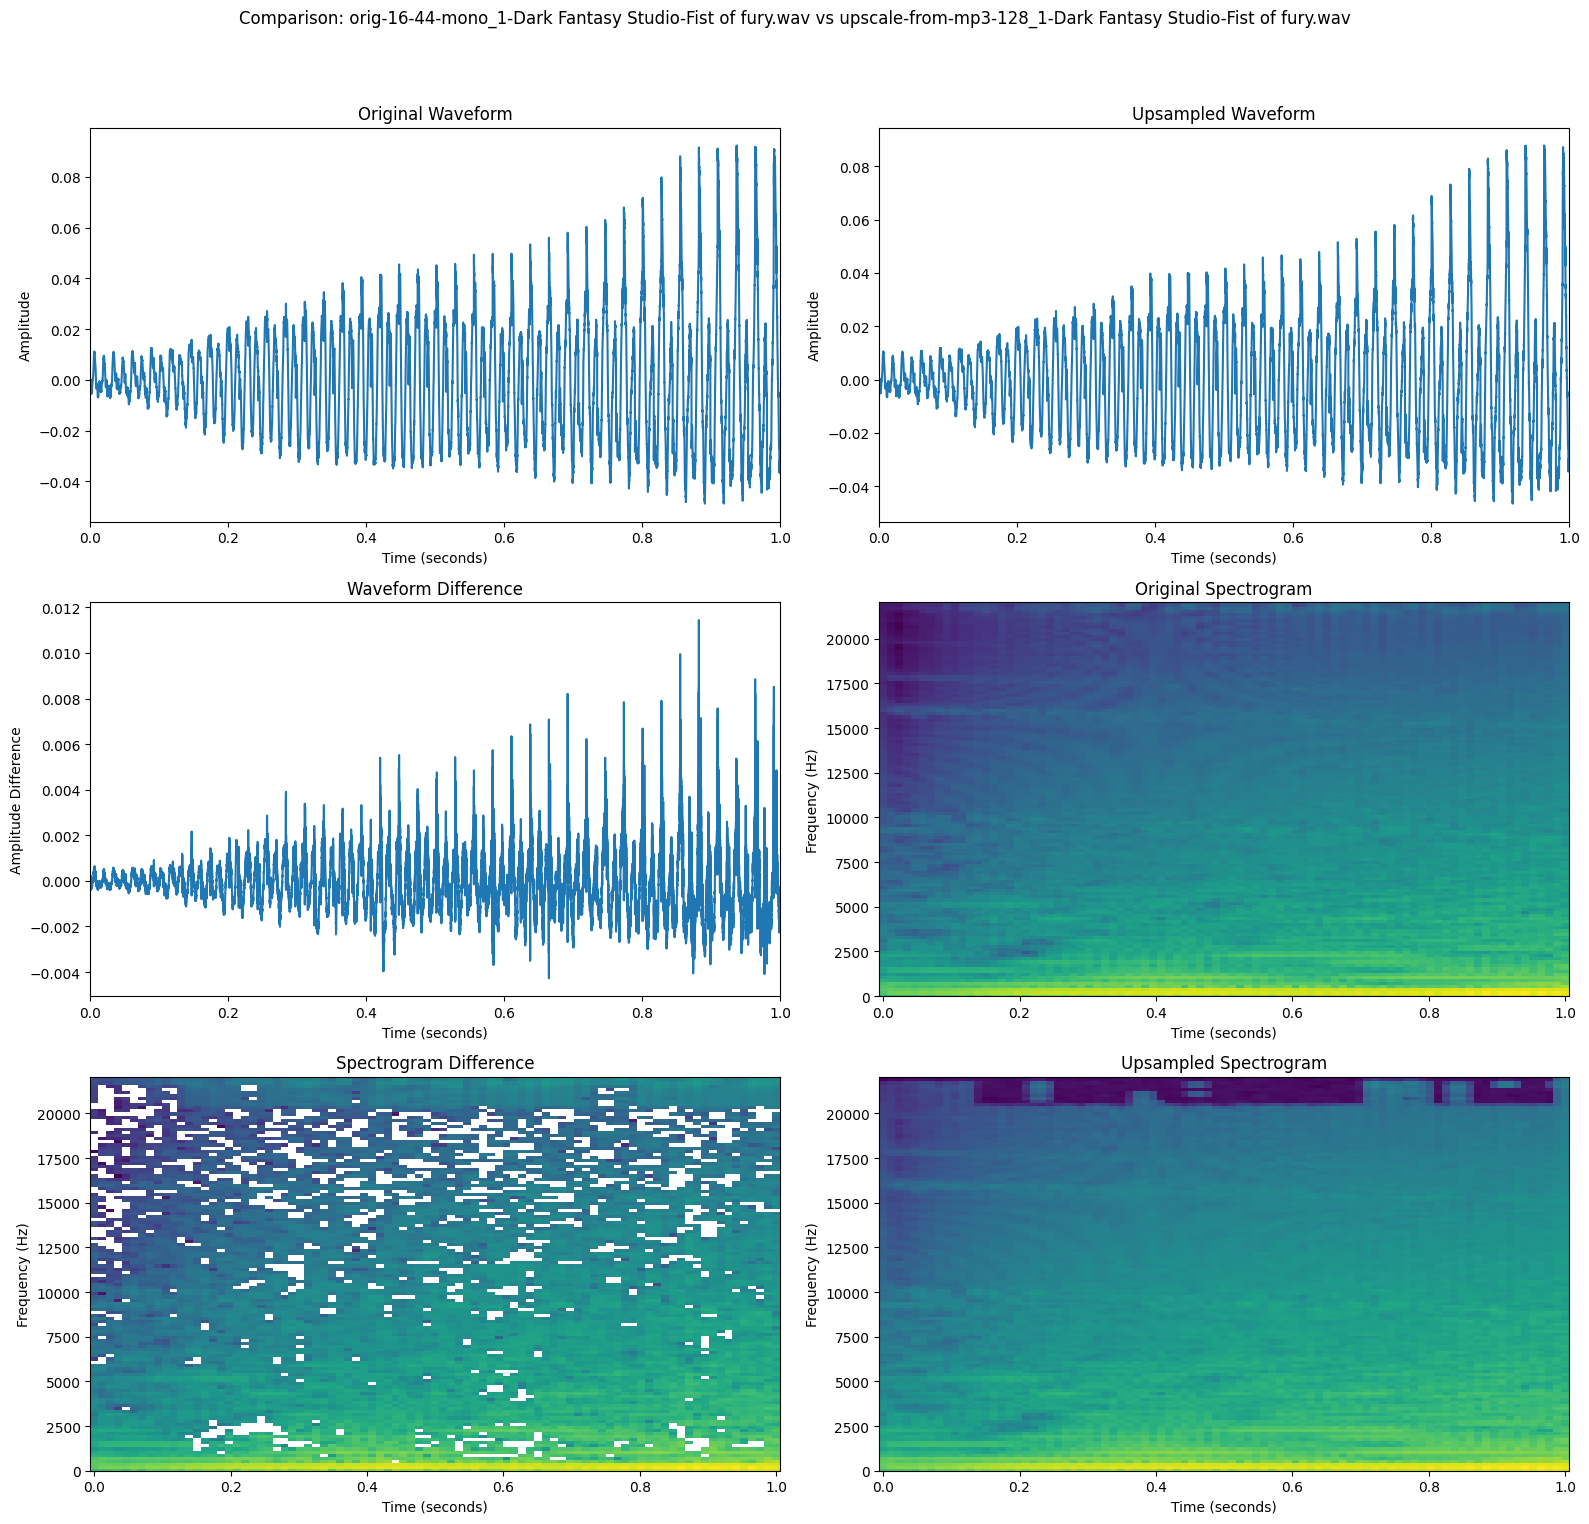

Loaded label_names (after play): ['orig-16-44-mono' 'upscale-from-mp3-128']


In [7]:
train_spectrogram_ds, val_spectrogram_ds, test_spectrogram_ds = wave_to_spec.run(label_names, train_ds, val_ds, test_ds, mel_spectogram)

## Build and train the model


In [8]:
# train_spectrogram_ds, val_spectrogram_ds, test_spectrogram_ds, session = build_train_model.run(train_spectrogram_ds, val_spectrogram_ds, test_spectrogram_ds, label_names, EPOCHS, RUNS_FIND_GOOD_AI)

## Handle AI Model


In [9]:
# model, path = handle_ai_model.run(TEST_DIR, test_spectrogram_ds, val_spectrogram_ds, train_spectrogram_ds, session, label_names, SECONDS)

# USE MODEL

In [10]:
# import ipynb.fs.defs.use_model as use_model

# use_model.run(path, SECONDS)

# LOOPS

Run: 20
Input shape: (128, 87, 1)
num_labels: 2
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_19 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_19 (Normaliza  (None, 32, 32, 1)        3         
 tion)                                                           
                                                                 
 conv2d_76 (Conv2D)          (None, 30, 30, 8)         80        
                                                                 
 batch_normalization_76 (Bat  (None, 30, 30, 8)        32        
 chNormalization)                                                
                                                                 
 conv2d_77 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 batc

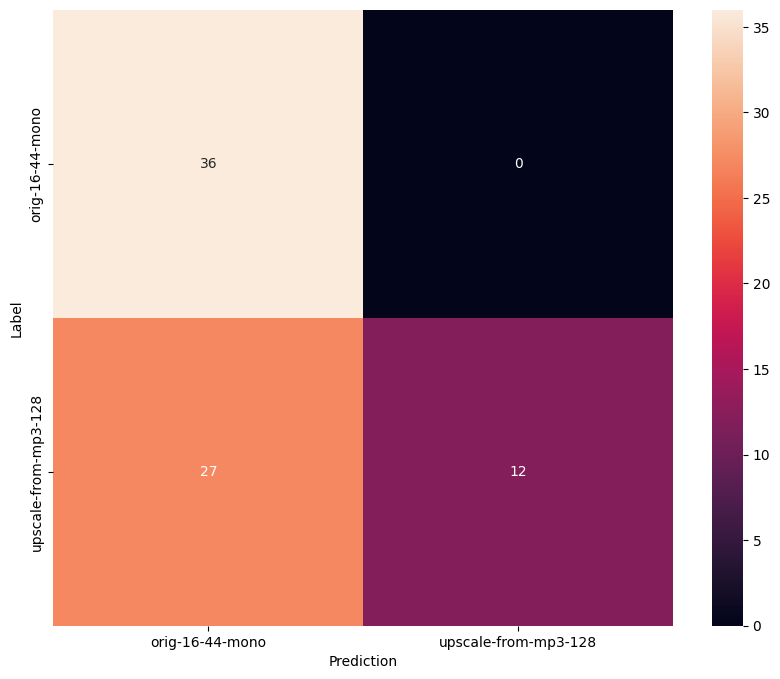

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x000001E52E579D60>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x000001E52E579D60>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x000001E52E579D60>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


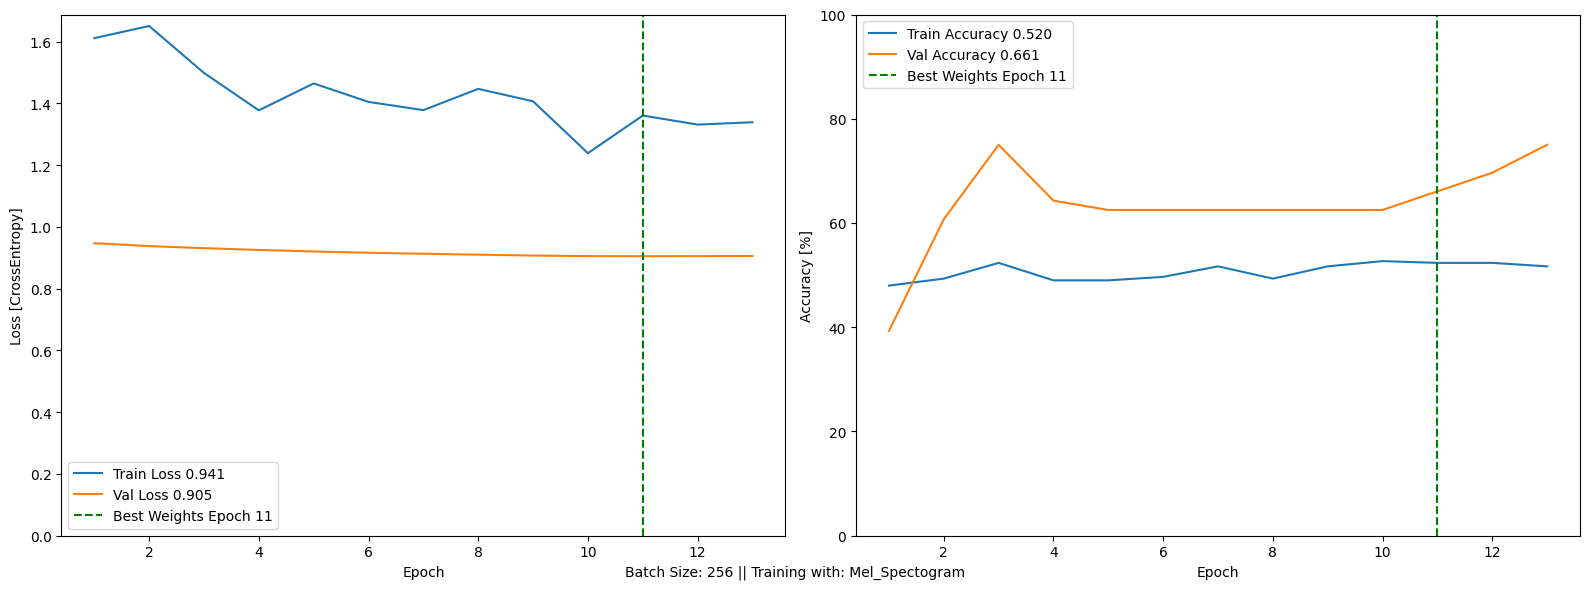

c:\Users\prett\anaconda3\envs\tf\lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


Used Model: saved_models/model_(298-1)_loss_0.941_acc_0.520_val_loss_0.905_val_acc_0.661.zip
Split test files in 1


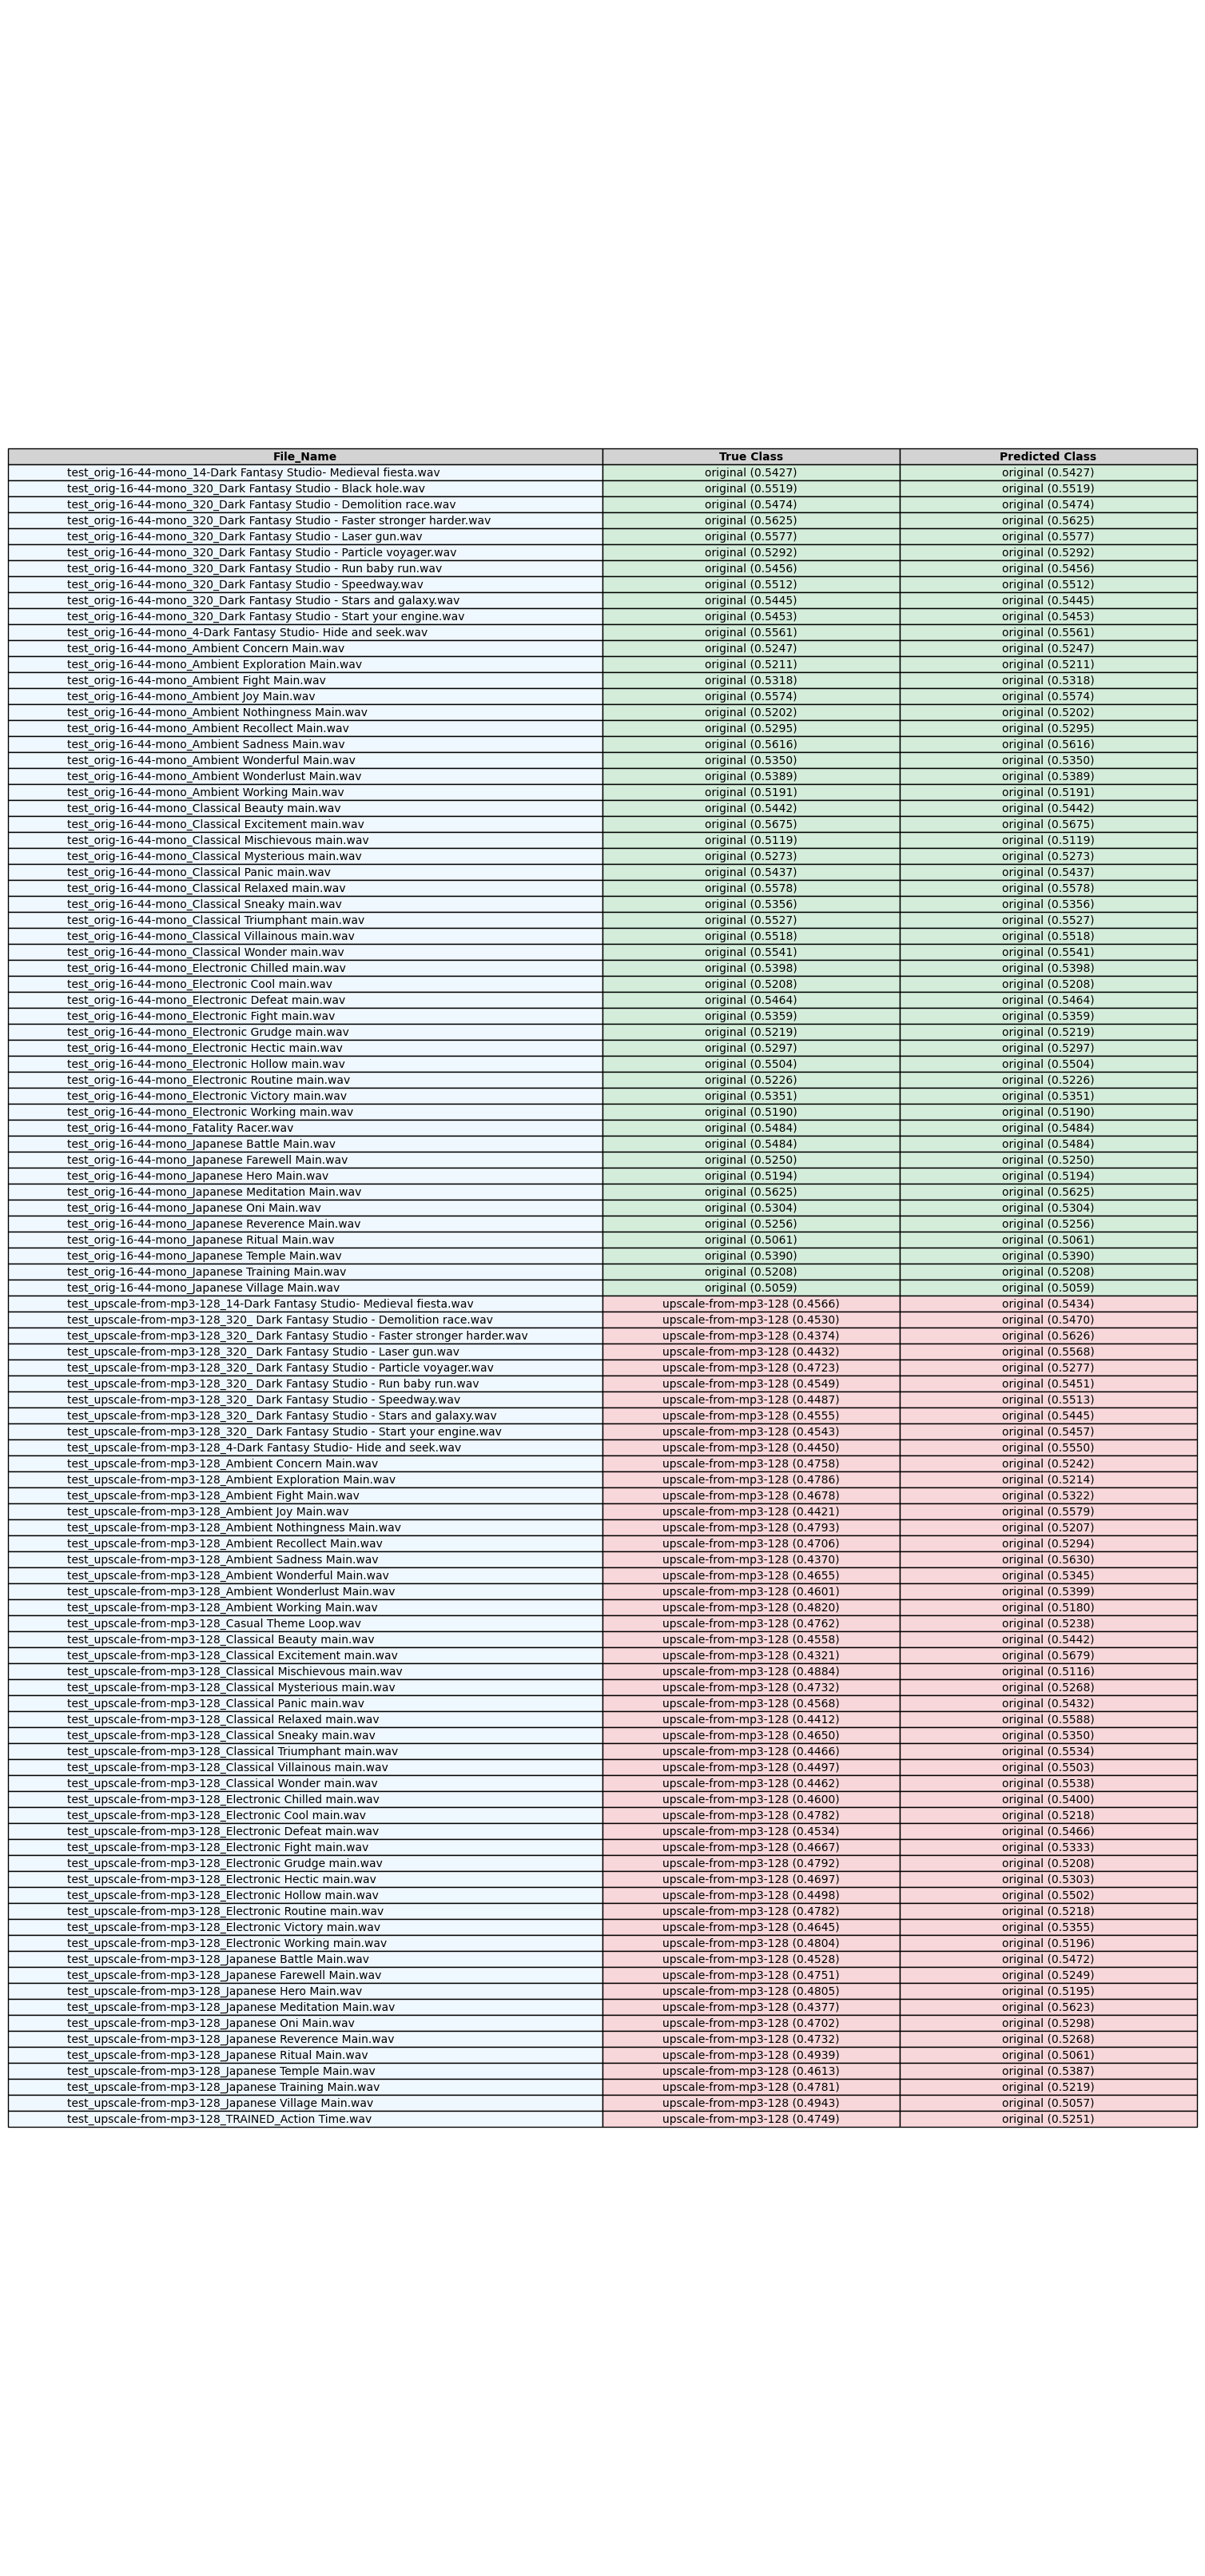

[{'File_Name': 'test_orig-16-44-mono_14-Dark Fantasy Studio- Medieval fiesta.wav', 'True Class': 'original (0.5427)', 'Predicted Class': 'original (0.5427)'}, {'File_Name': 'test_orig-16-44-mono_320_Dark Fantasy Studio - Black hole.wav', 'True Class': 'original (0.5519)', 'Predicted Class': 'original (0.5519)'}, {'File_Name': 'test_orig-16-44-mono_320_Dark Fantasy Studio - Demolition race.wav', 'True Class': 'original (0.5474)', 'Predicted Class': 'original (0.5474)'}, {'File_Name': 'test_orig-16-44-mono_320_Dark Fantasy Studio - Faster stronger harder.wav', 'True Class': 'original (0.5625)', 'Predicted Class': 'original (0.5625)'}, {'File_Name': 'test_orig-16-44-mono_320_Dark Fantasy Studio - Laser gun.wav', 'True Class': 'original (0.5577)', 'Predicted Class': 'original (0.5577)'}, {'File_Name': 'test_orig-16-44-mono_320_Dark Fantasy Studio - Particle voyager.wav', 'True Class': 'original (0.5292)', 'Predicted Class': 'original (0.5292)'}, {'File_Name': 'test_orig-16-44-mono_320_Dark

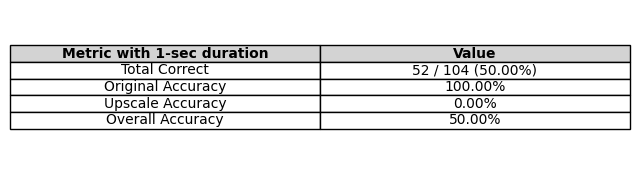

Haupttabelle als Bild gespeichert: saved_models\model_(298-1)_loss_0.941_acc_0.520_val_loss_0.905_val_acc_0.661_table.png
Zusammenfassungstabelle als Bild gespeichert: saved_models\model_(298-1)_loss_0.941_acc_0.520_val_loss_0.905_val_acc_0.661_summary.png


In [11]:
import ipynb.fs.defs.use_model as use_model
from IPython.display import clear_output

for i in range(RUNS_CREATE_AI):
    print(f"Run: {i+1}")
    train_spectrogram_ds, val_spectrogram_ds, test_spectrogram_ds, session = build_train_model.run(train_spectrogram_ds, val_spectrogram_ds, test_spectrogram_ds, label_names, EPOCHS, RUNS_FIND_GOOD_AI)
    model, path = handle_ai_model.run(TEST_DIR, test_spectrogram_ds, val_spectrogram_ds, train_spectrogram_ds, session, label_names, SECONDS, mel_spectogram)
    use_model.run(path, SECONDS)
    clear_output(wait=True)
    

In [12]:
# train_spectrogram_ds, val_spectrogram_ds, test_spectrogram_ds, model, history = build_train_model.run(train_spectrogram_ds, val_spectrogram_ds, test_spectrogram_ds, label_names)

In [13]:
# model, path = handle_ai_model.run(TEST_DIR, test_spectrogram_ds, val_spectrogram_ds, train_spectrogram_ds, history, model, label_names, SECONDS)

In [14]:
# import ipynb.fs.defs.use_model as use_model

# use_model.run(path, SECONDS)

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The
  [TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.
